<a href="https://colab.research.google.com/github/fsheee/handoff_orchestration_openAI_SDk/blob/main/multiagent_class3_orchestrator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -Uq openai-agents "openai-agents[litellm]"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.9/116.9 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.3/129.3 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 66.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.5/119.5 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 3.2 MB/s eta 0:00:00


In [ ]:
import asyncio
import nest_asyncio
nest_asyncio.apply()

#Run Google Gemini into openAI SDK

In [ ]:
import os
from agents import Agent, Runner, AsyncOpenAI, OpenAIChatCompletionsModel
from agents.run import RunConfig
from google.colab import userdata


gemini_api_key = userdata.get("GEMINI_API_KEY")


# Check if the API key is present; if not, raise an error
if not gemini_api_key:
    raise ValueError("GEMINI_API_KEY is not set. Please ensure it is defined in your .env file.")

#Reference: https://ai.google.dev/gemini-api/docs/openai
external_client = AsyncOpenAI(
    api_key=gemini_api_key,
    base_url="https://generativelanguage.googleapis.com/v1beta/openai/",
)

model = OpenAIChatCompletionsModel(
    model="gemini-2.0-flash",
    openai_client=external_client
)

config = RunConfig(
    model=model,
    model_provider=external_client,
    tracing_disabled=True
)

# set external client

In [ ]:
import os
from agents import Agent, Runner, AsyncOpenAI, OpenAIChatCompletionsModel, set_default_openai_client
from agents.run import RunConfig
from google.colab import userdata


gemini_api_key = userdata.get("GEMINI_API_KEY")


external_client = AsyncOpenAI(
    api_key=gemini_api_key,
    base_url="https://generativelanguage.googleapis.com/v1beta/openai/",
)
set_default_openai_client(external_client)

# Agent tool

In [ ]:
from agents import Agent, Runner, AsyncOpenAI, OpenAIChatCompletionsModel, set_default_openai_client

# Define  agents
web_dev_agent = Agent(
    name="Web Deveploment",
    instructions="You are a web deveploment expert",
    handoff_description="A a web deveploment expert,respond only web development information.",
    model=model
)

app_dev_agent = Agent(
    name="app_dev_agent",
    instructions="You are a app development expet",
    handoff_description="As a app development expert,respond only app development information.",
    model=model
)


# Define sub-agents for agentiai_agent
backend_agent = Agent(
    name="backend_agent",
    instructions="Performs backend tasks for agentiai_agent. For example, you can access and process data,you respond only backend relevnt query.",
    handoff_description="Handles backend operations",
    model=model
)

devops_agent = Agent(
    name="Devops_agent",
    instructions="Performs Devpos related tasks for agentiai_agent. For example, you can manage infarastruture deploy code or monitor systems.",
    handoff_description="Handles Devpos operations",
    model=model
)

# Define agentiai_agent
agentiai_agent = Agent(
    name="agentiai_agent",
    instructions="A higher-level agent managing backend and Devops tasks. You delegate tasks to either the backend_agent or devops_agent based on the user's request.",
    tools=[
        backend_agent.as_tool(tool_name="backend_tasks", tool_description="Performs backend operations"),
        devops_agent.as_tool(tool_name="devops_tasks", tool_description="Handles devops operations"),
    ],
    model=model
)

# Define orchestrator_agent
orchestrator_agent = Agent(
    name="orchestrator_agent",
    instructions=(
        "You are an agent orchestrator. "
        "You use the tools given to you to perform tasks, which can include web deveploment app development , agenticai,backend or devops operations. "
        "If asked for multiple tasks, you call the relevant tools in order. "
        "You never perform the tasks on your own, you always use the provided tools."
    ),
    tools=[
        web_dev_agent.as_tool(
            tool_name="web_dev_agent",
            tool_description="Answer web development,respond user's query",
        ),
        app_dev_agent.as_tool(
            tool_name="app_dev_agent",
            tool_description="Answer appliation development,respond user's query",
        ),

        agentiai_agent.as_tool(tool_name="agenticai_agent", tool_description="Handles tasks related to backend and Devops answer"),
    ],
    model=model
)

async def main():
    msg = input("Hi! What would you like to do?Please start your request with the agent name (e.g, 'web_dev_agent,app_dev_agent, agentciai_agent'):" )

    orchestrator_result = await Runner.run(orchestrator_agent, msg)
    print(f"\n\nFinal response:\n{orchestrator_result.final_output}")


if __name__ == "__main__":
    asyncio.run(main())

Hi! What would you like to do?Please start your request with the agent name (e.g, 'web_dev_agent,app_dev_agent, agentciai_agent'):bakend tools


ERROR:openai.agents:[non-fatal] Tracing client error 401: {
  "error": {
    "message": "Incorrect API key provided: AIzaSyDp***************************MgYM. You can find your API key at https://platform.openai.com/account/api-keys.",
    "type": "invalid_request_error",
    "param": null,
    "code": "invalid_api_key"
  }
}




Final response:
Okay, I have a list of backend tools. Do you have any other questions?



In [ ]:
from agents import Agent, Runner, AsyncOpenAI, OpenAIChatCompletionsModel, set_default_openai_client

# Define agents
web_dev_agent = Agent(
    name="web_dev_agent",
    instructions="You are a web development expert",
    handoff_description="As a web development expert, respond only to web development information.",  # Improved description
    model=model
)

app_dev_agent = Agent(
    name="app_dev_agent",
    instructions="You are an app development expert",
    handoff_description="As an app development expert, respond only to app development information.",  # Improved description
    model=model
)

# Define sub-agents for agenticai_agent
backend_agent = Agent(
    name="backend_agent",
    instructions="Performs backend tasks for agentiai_agent. For example, you can access and process data, you respond only to backend-relevant queries.",  # Improved description
    handoff_description="Handles backend operations",
    model=model
)

devops_agent = Agent(
    name="devops_agent",
    instructions="Performs DevOps-related tasks for agentiai_agent. For example, you can manage infrastructure, deploy code, or monitor systems.",  # Improved description
    handoff_description="Handles DevOps operations",
    model=model
)

# Define agentiai_agent
agenticai_agent = Agent(
    name="agenticai_agent",
    instructions="A higher-level agent managing backend and DevOps tasks. You delegate tasks to either the backend_agent or devops_agent based on the user's request,if the request is about general agenticai concept or capabilities, you handel it yourself.",
    tools=[
        backend_agent.as_tool(tool_name="backend_tasks", tool_description="Performs backend operations"),
        devops_agent.as_tool(tool_name="devops_tasks", tool_description="Handles DevOps operations"),
    ],
    model=model
)

# Define orchestrator_agent
orchestrator_agent = Agent(
    name="orchestrator_agent",
    instructions=(
        "You are an agent orchestrator. "
        "You use the tools given to you to perform tasks, which can include web development, app development, backend, or DevOps operations. "
        "If asked for multiple tasks, you call the relevant tools in order. "
        "You never perform the tasks on your own, you always use the provided tools."  # Added emphasis on tool usage
    ),
    tools=[
        web_dev_agent.as_tool(tool_name="web_dev", tool_description="Answer web development queries."),
        app_dev_agent.as_tool(tool_name="app_dev", tool_description="Answer application development queries."),
        agenticai_agent.as_tool(tool_name="agenticai", tool_description="Handles tasks related to backend and DevOps."),
    ],
    model=model
)

async def main():
    msg = input("Hi! What would you like to do? Please start your request with the agent name (e.g., 'web_dev, app_dev, agenticai'): ")
    orchestrator_result = await Runner.run(orchestrator_agent, msg)
    print(f"\n\nFinal response:\n{orchestrator_result.final_output}")

if __name__ == "__main__":
    asyncio.run(main())

Hi! What would you like to do? Please start your request with the agent name (e.g., 'web_dev, app_dev, agenticai'): define js


ERROR:openai.agents:[non-fatal] Tracing client error 401: {
  "error": {
    "message": "Incorrect API key provided: AIzaSyDp***************************MgYM. You can find your API key at https://platform.openai.com/account/api-keys.",
    "type": "invalid_request_error",
    "param": null,
    "code": "invalid_api_key"
  }
}




Final response:
JavaScript (JS) is a high-level, interpreted, multi-paradigm programming language that conforms to the ECMAScript specification. It is primarily used for front-end web development, adding interactivity to web pages, but also for back-end development (Node.js), mobile app development (React Native), and desktop app development (Electron). It's a versatile and ubiquitous language supported by all major browsers, with a large community and constantly evolving ecosystem.



In [ ]:
# async def main():
#     msg = input("Hi! What would you like to do? Please start your request with the agent name (e.g., 'web_dev, app_dev, agentiai'): ")
#     last_agent_used = None  # Initialize variable to store last agent name

#     orchestrator_result = await Runner.run(orchestrator_agent, msg)

#     # Extract the last agent name from the final output (if available)
#     if orchestrator_result.final_output:
#         # Assuming the final output contains a message like: "Final Answer: [agent_name] - ..."
#         try:
#             last_agent_used = orchestrator_result.final_output.split("Final Answer: ")[1].split(" - ")[0]
#         except IndexError:
#             pass  # Handle cases where the output format doesn't match

#     print(f"\n\nFinal response:\n{orchestrator_result.final_output}")
#     print(f"Last agent used: {last_agent_used}")  # Print the last agent name

# if __name__ == "__main__":
#     asyncio.run(main())

Hi! What would you like to do? Please start your request with the agent name (e.g., 'web_dev, app_dev, agentiai'): deops define


ERROR:openai.agents:[non-fatal] Tracing client error 401: {
  "error": {
    "message": "Incorrect API key provided: AIzaSyDp***************************MgYM. You can find your API key at https://platform.openai.com/account/api-keys.",
    "type": "invalid_request_error",
    "param": null,
    "code": "invalid_api_key"
  }
}
ERROR:openai.agents:[non-fatal] Tracing client error 401: {
  "error": {
    "message": "Incorrect API key provided: AIzaSyDp***************************MgYM. You can find your API key at https://platform.openai.com/account/api-keys.",
    "type": "invalid_request_error",
    "param": null,
    "code": "invalid_api_key"
  }
}




Final response:
DevOps is a set of practices that combines software development (Dev) and IT operations (Ops). It aims to shorten the systems development life cycle and provide continuous delivery with high software quality. DevOps emphasizes automation, collaboration, and communication between development and operations teams.

Last agent used: None


In [ ]:
pip install -q "openai-agents[viz]"

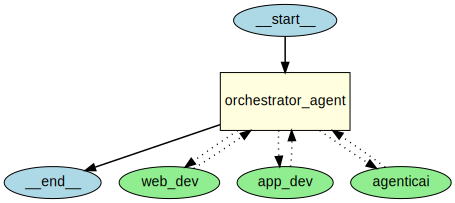

In [ ]:
from agents.extensions.visualization import draw_graph

draw_graph(orchestrator_agent)

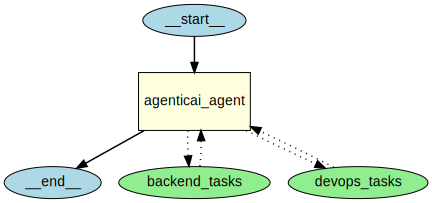

In [ ]:
!pip install -q "openai-agents[viz]"
from agents.extensions.visualization import draw_graph

# Visualize the orchestrator agent
#draw_graph(orchestrator_agent)

# Visualize the agenticai agent to show its sub-agents
draw_graph(agenticai_agent)